In [65]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize

In [93]:
def find_the_primes_numbers(number_1:int, list_primes:list[int]):
    '''
    This function finds the two prime numbers that make up the number_1. (Goldbach's conjecture)

    Parameters
    ----------
    number_1 : int
        The number to be decomposed into prime numbers.
    list_primes : list[int]
        List of prime numbers.
    
    Returns
    -------
    list[int]
        List of two prime numbers that make up the number_1.
    '''

    # Identify the number of qubits needed to represent the largest number in the list of prime numbers.
    max_number = np.max(list_primes)
    num_qubits_max_number = int(np.ceil( np.log2( max_number ) ))

    # Compute the initial state as an uniform superposition of all possible prime numbers contained in the list.
    input_state = np.zeros( 2**num_qubits_max_number, dtype=np.complex128 )
    for prime in list_primes:
        input_state[prime] = 1
    input_state /= np.sqrt( len(list_primes) )

    q_r_numberA = QuantumRegister(num_qubits_max_number, name='A')
    q_r_numberB = QuantumRegister(num_qubits_max_number, name='B')
    q_r_carry = QuantumRegister(num_qubits_max_number, name='Carry')

    c_r_number = ClassicalRegister(num_qubits_max_number + 1, name='Result')

    qc = QuantumCircuit(q_r_numberA, q_r_numberB, q_r_carry, c_r_number)

    # ------------------------------------------------------------ #
    # ---------------------- Operator A -------------------------- #
    # ------------------------------------------------------------ #
    
    init_primes_state = Initialize(input_state)
    qc.append(init_primes_state, q_r_numberA)
    qc.append(init_primes_state, q_r_numberB)

    # Add both registers
    for i in range(num_qubits_max_number):
        qc.ccx(q_r_numberA[i], q_r_numberB[i], q_r_carry[i])
        qc.cx(q_r_numberA[i], q_r_numberB[i])
        if i > 0:
            qc.ccx(q_r_numberB[i], q_r_carry[i-1], q_r_carry[i])
            qc.cx(q_r_carry[i-1], q_r_numberB[i])
        qc.barrier()
    
    [qc.measure(q_r_numberB[i], c_r_number[i]) for i in range(num_qubits_max_number)]
    qc.measure(q_r_carry[-1], c_r_number[-1])

    display(qc.draw('mpl'))

    # ------------------------------------------------------------ #

    # Execute the circuit
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1_000)
    result = job.result()
    counts = result.get_counts()

    # Histogram of the results
    display(plot_histogram(counts))

    numbers = list( map( lambda x:int(x, 2), counts.keys()))
    # Sort the numbers
    numbers.sort()
    print(f'Numbers: {numbers}')



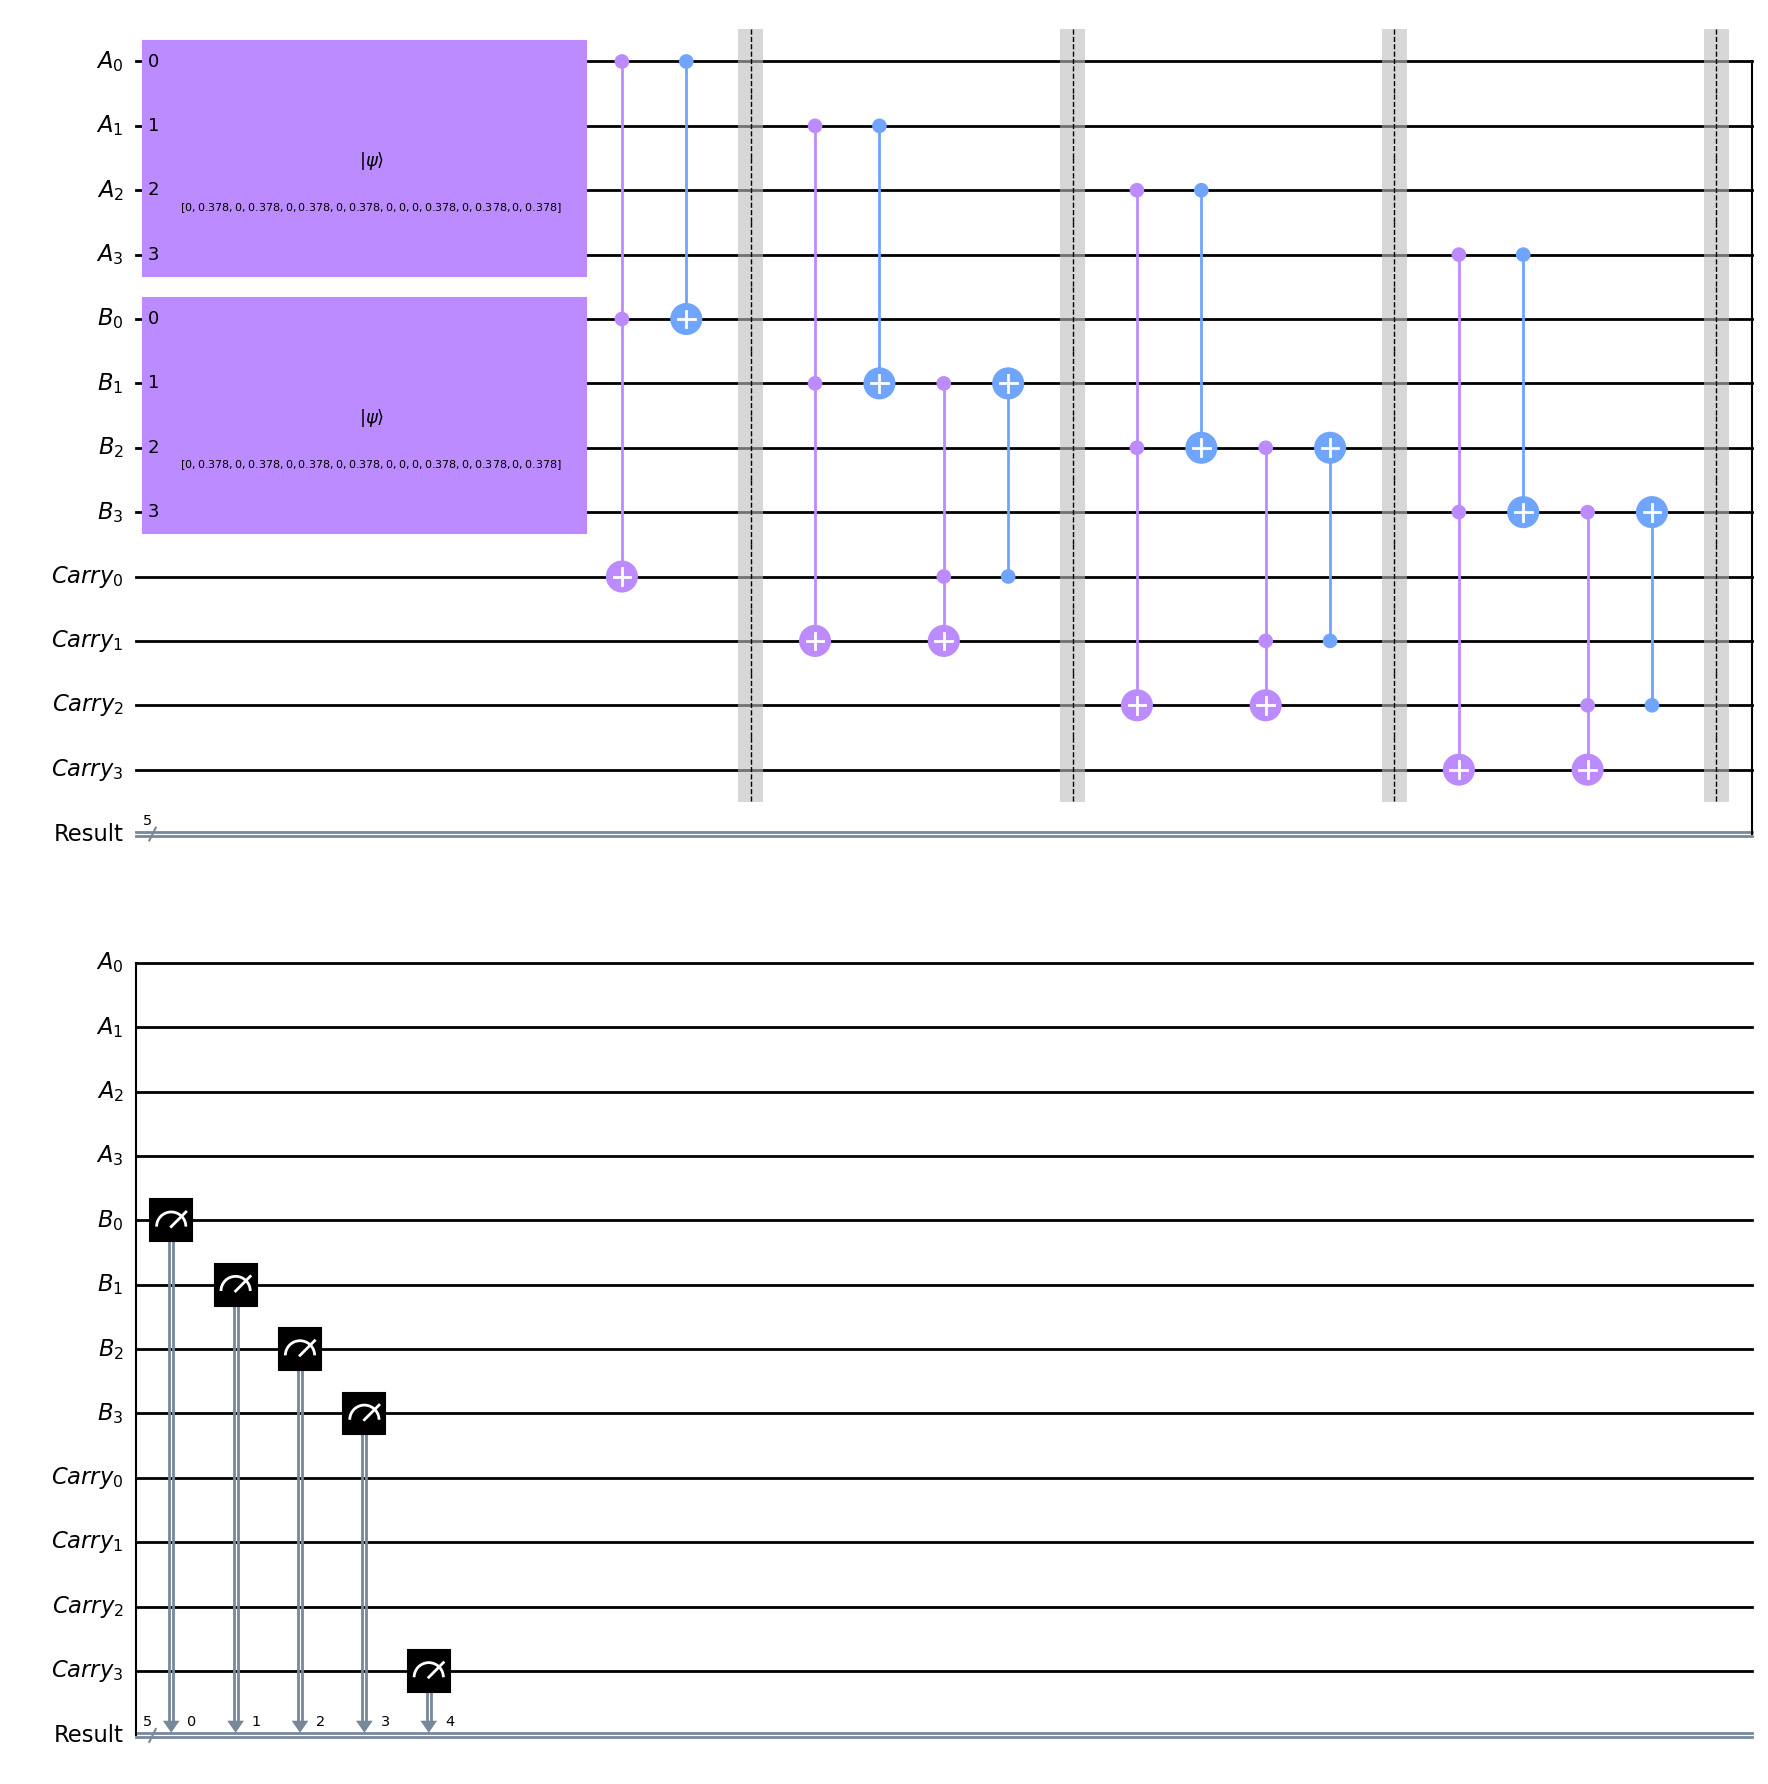

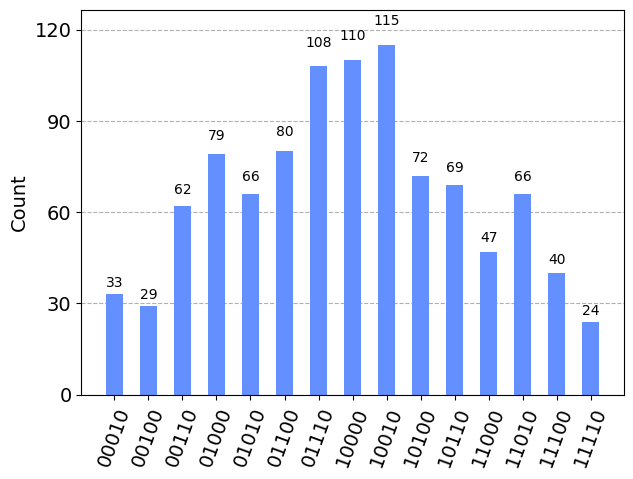

Numbers: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


In [94]:
find_the_primes_numbers (18, [1,3,5,7,11,13,15])